In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_users = 1000  # Number of users
data = {
    "user_id": np.arange(1, n_users + 1),
    "age": np.random.randint(18, 65, size=n_users),
    "location": np.random.choice(["US", "UK", "Canada", "Australia"], size=n_users),
    "subscription_tier": np.random.choice(["Basic", "Mid", "Premium"], size=n_users, p=[0.5, 0.3, 0.2]),
    "price": np.random.choice([9.99, 14.99, 19.99], size=n_users, p=[0.5, 0.3, 0.2]),
    "payment_method": np.random.choice(["Credit Card", "PayPal", "Other"], size=n_users),
    "hours_watched": np.random.normal(50, 15, size=n_users).clip(0, 100),  # Clip to ensure no negative values
    "churn": np.random.choice([0, 1], size=n_users, p=[0.8, 0.2]),  # 20% churn rate
    "revenue": np.random.normal(15, 5, size=n_users).clip(10, 20)  # Simulated revenue
}

# Create DataFrame
df = pd.DataFrame(data)

# Save to CSV (optional)
df.to_csv("subscription_data.csv", index=False)

# Display the first few rows
print(df.head())

   user_id  age   location subscription_tier  price payment_method  \
0        1   56         US               Mid   9.99          Other   
1        2   46  Australia             Basic  19.99          Other   
2        3   32         UK             Basic   9.99         PayPal   
3        4   60  Australia           Premium  19.99    Credit Card   
4        5   25         US             Basic  14.99          Other   

   hours_watched  churn    revenue  
0      63.410744      0  15.212852  
1      42.549338      0  20.000000  
2      49.245755      0  10.000000  
3      40.413147      0  18.126491  
4      27.236943      0  14.586768  


           user_id          age        price  hours_watched        churn  \
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.000000   
mean    500.500000    40.986000    13.455000      49.375920     0.199000   
std     288.819436    13.497852     3.890233      14.909699     0.399448   
min       1.000000    18.000000     9.990000       0.000000     0.000000   
25%     250.750000    29.000000     9.990000      38.669288     0.000000   
50%     500.500000    42.000000     9.990000      49.441224     0.000000   
75%     750.250000    52.000000    14.990000      60.473121     0.000000   
max    1000.000000    64.000000    19.990000      93.811288     1.000000   

           revenue  
count  1000.000000  
mean     15.097671  
std       3.668143  
min      10.000000  
25%      11.598636  
50%      15.138533  
75%      18.700958  
max      20.000000  


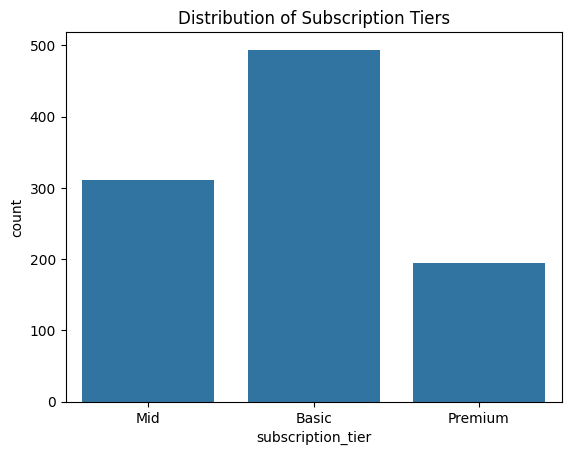

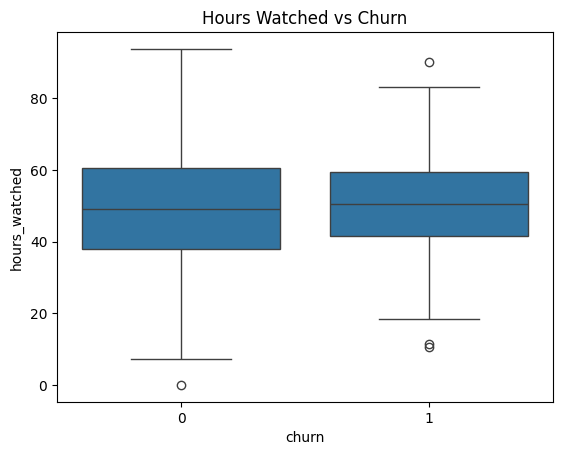

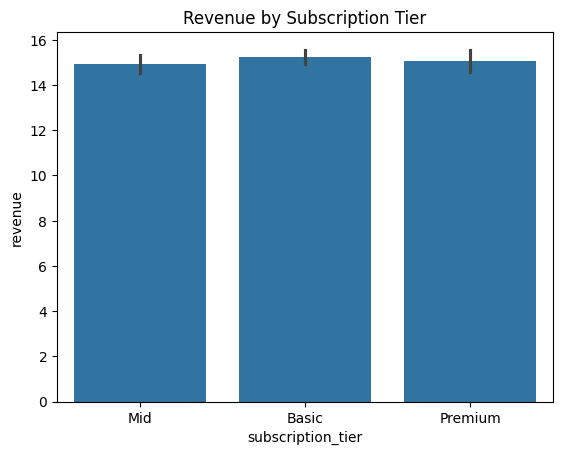

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary statistics
print(df.describe())

# Distribution of subscription tiers
sns.countplot(x="subscription_tier", data=df)
plt.title("Distribution of Subscription Tiers")
plt.show()

# Correlation between hours watched and churn
sns.boxplot(x="churn", y="hours_watched", data=df)
plt.title("Hours Watched vs Churn")
plt.show()

# Revenue by subscription tier
sns.barplot(x="subscription_tier", y="revenue", data=df)
plt.title("Revenue by Subscription Tier")
plt.show()

In [ ]:
from scipy import stats

# Simulate A/B test data
# Group A: Existing pricing (Basic: $9.99, Premium: $19.99)
# Group B: New pricing (Basic: $9.99, Mid: $14.99, Premium: $19.99)
group_a = df[df["subscription_tier"].isin(["Basic", "Premium"])].copy()
group_b = df.copy()  # Introduce Mid tier for Group B
group_b.loc[group_b["subscription_tier"] == "Mid", "price"] = 14.99

# Compare churn rates between groups
churn_rate_a = group_a["churn"].mean()
churn_rate_b = group_b["churn"].mean()

print(f"Churn Rate (Group A): {churn_rate_a:.2f}")
print(f"Churn Rate (Group B): {churn_rate_b:.2f}")

# Perform t-test to check significance
t_stat, p_value = stats.ttest_ind(group_a["churn"], group_b["churn"])
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

Churn Rate (Group A): 0.19
Churn Rate (Group B): 0.20
T-statistic: -0.23, P-value: 0.8188


In [ ]:
!pip install causalinference

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import LogisticRegression

# Add a treatment indicator (1 for Group B, 0 for Group A)
group_a["treatment"] = 0
group_b["treatment"] = 1
combined_data = pd.concat([group_a, group_b])

# Fit a propensity score model
model = LogisticRegression()
model.fit(combined_data[["age", "hours_watched", "revenue"]], combined_data["treatment"])
combined_data["propensity_score"] = model.predict_proba(combined_data[["age", "hours_watched", "revenue"]])[:, 1]

# Match users based on propensity scores
from causalinference import CausalModel

cm = CausalModel(
    Y=combined_data["churn"].values,  # Outcome (churn)
    D=combined_data["treatment"].values,  # Treatment (new pricing tier)
    X=combined_data[["age", "hours_watched", "revenue"]].values  # Covariates
)

cm.est_propensity_s()
cm.est_via_matching(bias_adj=True)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.002      0.011      0.219      0.826     -0.019      0.023
           ATC      0.000      0.013      0.000      1.000     -0.025      0.025
           ATT      0.004      0.010      0.384      0.701     -0.016      0.024



/usr/local/lib/python3.11/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [ ]:
# Calculate ARPU
arpu = df["revenue"].mean()
print(f"Average Revenue Per User (ARPU): ${arpu:.2f}")

# Calculate CLV (simplified: CLV = ARPU * average lifetime in months)
average_lifetime = 1 / df["churn"].mean()  # Simplified churn-based lifetime
clv = arpu * average_lifetime
print(f"Customer Lifetime Value (CLV): ${clv:.2f}")

Average Revenue Per User (ARPU): $15.10
Customer Lifetime Value (CLV): $75.87
